# Energy balance evaluation
*J. Michelle Hu  
University of Utah  
August 2024*  
---

In [1]:
import os
import sys
import xarray as xr

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

from shapely.geometry import Point

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# Set environmental variable for PROJ to directory where you can find proj.db
os.environ['PROJ']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'
os.environ['PROJLIB']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'

## Directory

In [16]:
basin = 'animas'
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/'
basindirs = h.fn_list(workdir, f'__{basin}*isnobal/')
basindirs

['/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/__animas_100m_isnobal/']

In [17]:
# Get the WY from the directory name
WY = int(h.fn_list(basindirs[0], '*')[0].split('/')[-1].split('wy')[-1])
WY

2021

### Load the data for the specified date

In [36]:
dt = '1027' 
em_fnlist = [h.fn_list(basindir, f'*{WY}/*/run{WY-1}{dt}/em.nc')[0] for basindir in basindirs]
em_list = [np.squeeze(xr.open_dataset(em_fn)) for em_fn in em_fnlist]
print(em_fnlist)


['/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/__animas_100m_isnobal/wy2021/animas_basin/run20201027/em.nc']


### Plot all energy terms for this day

In [37]:
# All variables in em.nc files
em_list[0].data_vars

Data variables:
    net_rad          (y, x) float32 2MB ...
    sensible_heat    (y, x) float32 2MB ...
    latent_heat      (y, x) float32 2MB ...
    snow_soil        (y, x) float32 2MB ...
    precip_advected  (y, x) float32 2MB ...
    sum_EB           (y, x) float32 2MB ...
    evaporation      (y, x) float32 2MB ...
    snowmelt         (y, x) float32 2MB ...
    SWI              (y, x) float32 2MB ...
    cold_content     (y, x) float32 2MB ...
    projection       |S1 1B ...

./animas_eb_terms_20211027.png


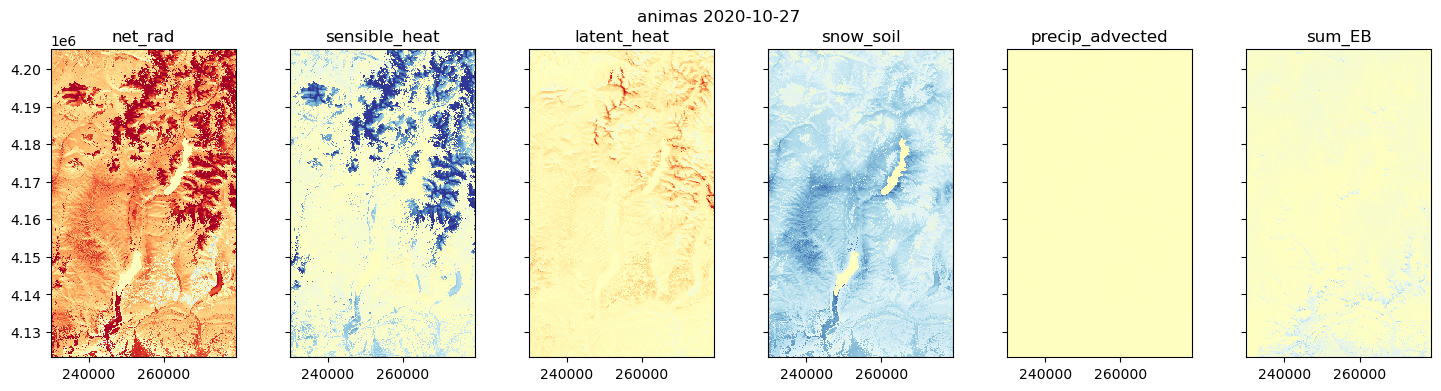

In [46]:
ds = em_list[0]
cmap = 'RdYlBu'
vmin = -50
vmax = 50
fig, axa = plt.subplots(1, 6, figsize=(18,4), sharex=True, sharey=True)
for jdx, thisvar in enumerate(em_list[0].data_vars):
    if jdx < len(em_list[0].data_vars) - 5:
        # print(thisvar)
        ax=axa.flatten()[jdx]
        # plot without colorbar
        ds[thisvar].plot.imshow(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)
        ax.set_aspect('equal')
        ax.set_title(thisvar)
        ax.set_xlabel('')
        ax.set_ylabel('')
plt.suptitle(f'{basin} {np.datetime_as_string(ds.time.values, unit="D")}');
outdir = '.'
outpath = f'{outdir}/{basin}_eb_terms_{WY}{dt}.png'
print(outpath)
plt.savefig(outpath, dpi=300, bbox_inches='tight')

## Specify a point for time series evaluation

Retrieved geodataframe of Cascade #2 (387) SNOTEL site and dataframe for WY 2021


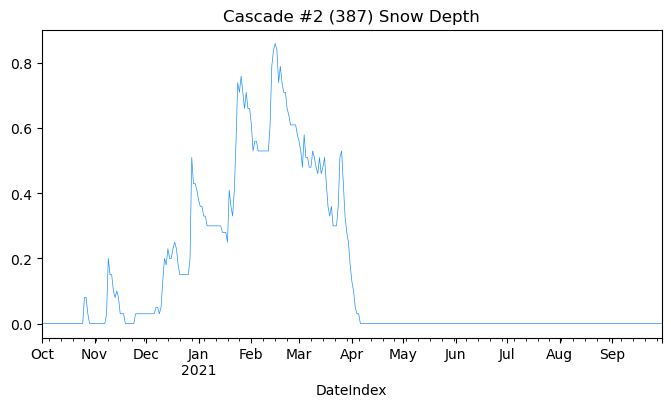

In [9]:
snotel_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL'
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/isnobal_scripts'

# Basin polygon file
poly_fn = h.fn_list(script_dir, f'*{basin}*setup/polys/*shp')[0]

# SNOTEL all sites geojson fn
allsites_fn = h.fn_list(snotel_dir, 'snotel_sites_32613.json')[0]

# Locate SNOTEL sites within basin
found_sites = proc.locate_snotel_in_poly(poly_fn=poly_fn, site_locs_fn=allsites_fn)

# Get site names and site numbers
site_names = found_sites['site_name']
sitenums = found_sites['site_num']

snotel_df, gdf, sitenum, sitename = proc.get_snotel_df_pt(snotel_dir=snotel_dir, sitenums=sitenums, WY=WY)
linestyle = '-' #':'
linewidth = 0.5
marker = None
color = 'k'
snotelcolors = ['dodgerblue', 'gray']

figsize = (8,4)
fig, ax = plt.subplots (1, figsize=figsize)
(snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100).plot(ax=ax, 
                                                                label=f'{sitename} Snow Depth [m]', 
                                                                linestyle=linestyle, 
                                                                linewidth=linewidth, 
                                                                color=snotelcolors[0], 
                                                                marker=marker
                                                                )
plt.title(f'{sitename} Snow Depth');

## Plot terms for this location for the entire water year

### Load data

In [60]:
%%time
basindirs = h.fn_list(workdir, f'__{basin}*isnobal/')
em_fnlists = [h.fn_list(basindir, f'*{WY}/*/run*/em.nc') for basindir in basindirs]
len(em_fnlists[0])

CPU times: user 7.88 ms, sys: 23.4 ms, total: 31.3 ms
Wall time: 76.5 ms


350

In [61]:
em_list = [xr.open_dataset(em_fn) for em_fn in em_fnlists[0]]

In [62]:
basindirs[0]

'/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/__animas_100m_isnobal/'

In [63]:
len(em_list)

350

## Create a dict of variables with data from specified point to plot

In [64]:
%%time
ds_list = em_list[0]
var_ts_dict = dict()

for jdx, thisvar in enumerate(ds_list.data_vars):
    if jdx < len(ds_list.data_vars) - 5:
        print(thisvar)
        var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in em_list]
        # updated_var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_list]

        # Concatenate all the days
        var_data = np.squeeze(xr.concat(var_data, dim='time'))
        # updated_var_data = xr.concat(updated_var_data, dim='time')
        
        var_ts_dict[thisvar] = var_data

net_rad
sensible_heat
latent_heat
snow_soil
precip_advected
sum_EB
CPU times: user 18.1 s, sys: 7.1 s, total: 25.2 s
Wall time: 48.3 s


CPU times: user 28.4 ms, sys: 1.75 ms, total: 30.2 ms
Wall time: 29.1 ms


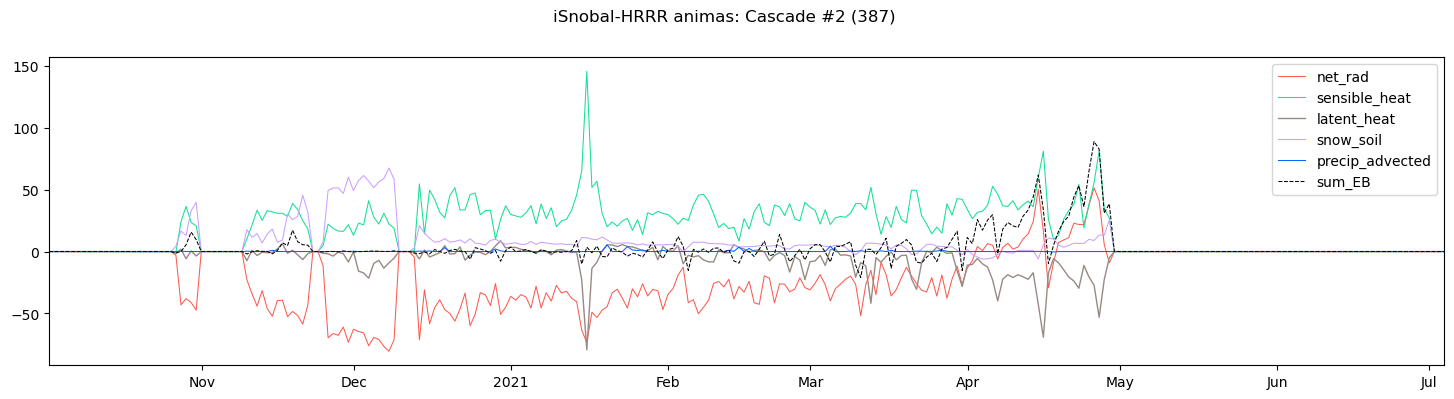

In [65]:
%%time
colors = ['xkcd:coral', 'xkcd:aqua green', 'xkcd:warm grey', 'xkcd:pastel purple', 'xkcd:bright blue', 'k']
linewidths = [0.75, 0.75, 1, 0.75, 0.75, 0.75]
linestyles = ['-', '-', '-', '-', '-', '--']
fig, ax = plt.subplots(figsize=(18, 4))
for jdx, thisvar in enumerate(var_ts_dict.keys()):
    var_ts_dict[thisvar].plot(x='time', ax=ax, label=thisvar, color=colors[jdx], linewidth=linewidths[jdx], linestyle=linestyles[jdx])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.set_xlim([var_ts_dict[thisvar].time.values[0], var_ts_dict[thisvar].time.values[-75]])
plt.suptitle(f'iSnobal-HRRR {basin}: {sitename}', y=1.0);
plt.legend();

# MODIS-HRRR version old

In [66]:
%%time
basindirs = h.fn_list(workdir, f'__{basin}*isnobal*albedo/')
print(basindirs[0])
em_fnlists = [h.fn_list(basindir, f'*{WY}/*/run*/em.nc') for basindir in basindirs]
len(em_fnlists[0])

/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/__animas_100m_isnobal_solar_albedo/
CPU times: user 9.61 ms, sys: 14.9 ms, total: 24.5 ms
Wall time: 70.9 ms


362

In [67]:
em_list = [xr.open_dataset(em_fn) for em_fn in em_fnlists[0]]
len(em_list)

362

## Create a dict of variables with data from specified point to plot

net_rad
sensible_heat
latent_heat
snow_soil
precip_advected
sum_EB
CPU times: user 19.8 s, sys: 7.29 s, total: 27.1 s
Wall time: 59.2 s


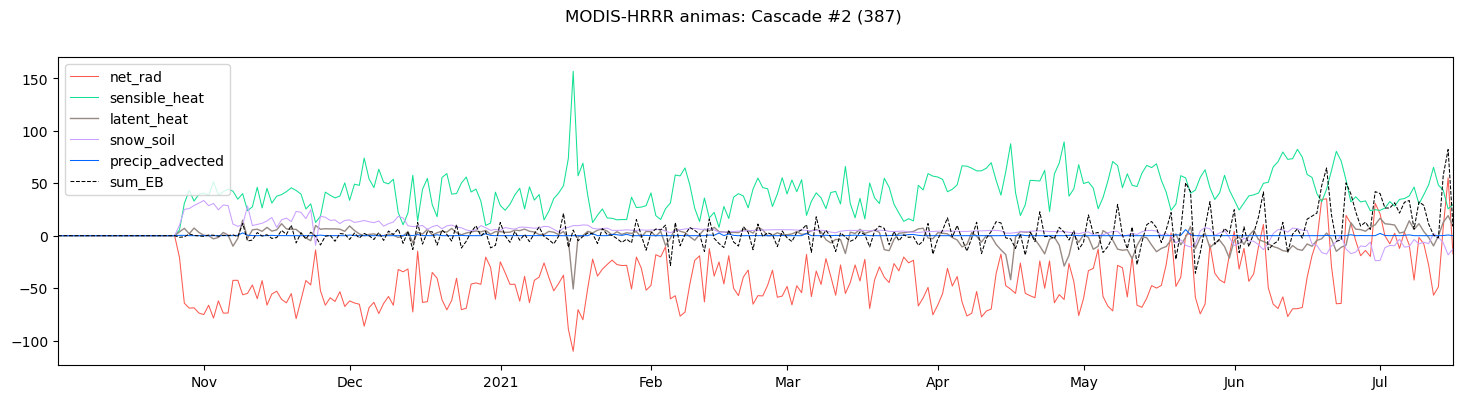

In [68]:
%%time
ds_list = em_list[0]
var_ts_dict = dict()

for jdx, thisvar in enumerate(ds_list.data_vars):
    if jdx < len(ds_list.data_vars) - 5:
        print(thisvar)
        var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in em_list]
        # updated_var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_list]

        # Concatenate all the days
        var_data = np.squeeze(xr.concat(var_data, dim='time'))
        # updated_var_data = xr.concat(updated_var_data, dim='time')
        
        var_ts_dict[thisvar] = var_data

fig, ax = plt.subplots(figsize=(18, 4))
for jdx, thisvar in enumerate(var_ts_dict.keys()):
    var_ts_dict[thisvar].plot(x='time', ax=ax, label=thisvar, color=colors[jdx], linewidth=linewidths[jdx], linestyle=linestyles[jdx])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.set_xlim([var_ts_dict[thisvar].time.values[0], var_ts_dict[thisvar].time.values[-75]])
plt.suptitle(f'MODIS-HRRR {basin}: {sitename}', y=1.0);
plt.legend();

# MODIS-HRRR version reprocessed

In [69]:
%%time
basindirs = h.fn_list(workdir, f'{basin}*isnobal*albedo/')
print(basindirs[0])
em_fnlists = [h.fn_list(basindir, f'*{WY}/*/run*/em.nc') for basindir in basindirs]
len(em_fnlists[0])

/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/animas_100m_isnobal_solar_albedo/
CPU times: user 22.1 ms, sys: 60.4 ms, total: 82.5 ms
Wall time: 10.7 s


362

In [70]:
em_list = [xr.open_dataset(em_fn) for em_fn in em_fnlists[0]]
len(em_list)

362

## Create a dict of variables with data from specified point to plot

net_rad
sensible_heat
latent_heat
snow_soil
precip_advected
sum_EB
CPU times: user 19.6 s, sys: 7.3 s, total: 26.9 s
Wall time: 55.5 s


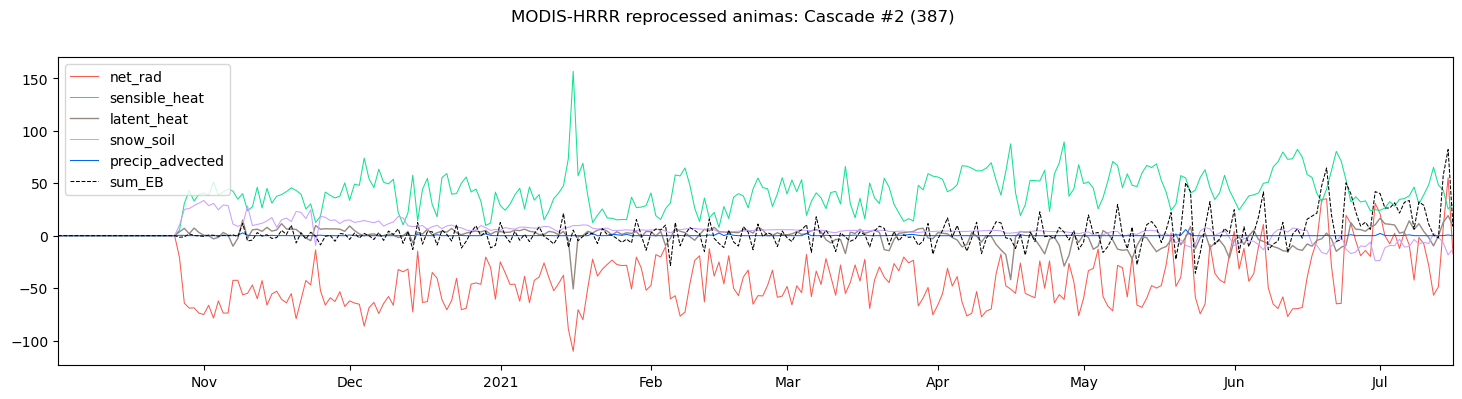

In [71]:
%%time
ds_list = em_list[0]
var_ts_dict = dict()

for jdx, thisvar in enumerate(ds_list.data_vars):
    if jdx < len(ds_list.data_vars) - 5:
        print(thisvar)
        var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in em_list]
        # updated_var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_list]

        # Concatenate all the days
        var_data = np.squeeze(xr.concat(var_data, dim='time'))
        # updated_var_data = xr.concat(updated_var_data, dim='time')
        
        var_ts_dict[thisvar] = var_data

fig, ax = plt.subplots(figsize=(18, 4))
for jdx, thisvar in enumerate(var_ts_dict.keys()):
    var_ts_dict[thisvar].plot(x='time', ax=ax, label=thisvar, color=colors[jdx], linewidth=linewidths[jdx], linestyle=linestyles[jdx])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.set_xlim([var_ts_dict[thisvar].time.values[0], var_ts_dict[thisvar].time.values[-75]])
plt.suptitle(f'MODIS-HRRR reprocessed {basin}: {sitename}', y=1.0);
plt.legend();

# All of them

In [83]:
from pathlib import PurePath

In [84]:
h.fn_list(workdir, f'*{basin}*')

['/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/__animas_100m_isnobal',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/__animas_100m_isnobal_solar_albedo',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/animas_100m_isnobal',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/animas_100m_isnobal_solar_albedo']

In [73]:
%%time
basindir = h.fn_list(workdir, f'{basin}*isnobal*albedo/')[0]
basindir


CPU times: user 69 µs, sys: 579 µs, total: 648 µs
Wall time: 689 µs


'/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/animas_100m_isnobal_solar_albedo/'

In [74]:
em_fnlist = h.fn_list(basindir, f'*{WY}/*/run*/em.nc')
len(em_fnlist)

362

In [75]:
em_list = [xr.open_dataset(em_fn) for em_fn in em_fnlist]
len(em_list)

362

## Create a dict of variables with data from specified point to plot

In [86]:
complete_dict = dict()
for basindir in h.fn_list(workdir, f'*{basin}*'):
    print(PurePath(basindir).name)
    em_fnlist = h.fn_list(basindir, f'*{WY}/*/run*/em.nc')
    print(len(em_fnlist))
    em_list = [xr.open_dataset(em_fn) for em_fn in em_fnlist]
    print(len(em_list))

    ds_list = em_list[0]
    var_ts_dict = dict()

    for jdx, thisvar in enumerate(ds_list.data_vars):
        if jdx < len(ds_list.data_vars) - 5:
            print(thisvar)
            var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in em_list]
            # Concatenate all the days
            var_data = np.squeeze(xr.concat(var_data, dim='time'))
            var_ts_dict[thisvar] = var_data
    
    complete_dict[PurePath(basindir).name] = var_ts_dict


__animas_100m_isnobal
350
350
net_rad
sensible_heat
latent_heat
snow_soil
precip_advected
sum_EB
__animas_100m_isnobal_solar_albedo
362
362
net_rad
sensible_heat
latent_heat
snow_soil
precip_advected
sum_EB
animas_100m_isnobal
30
30
net_rad
sensible_heat
latent_heat
snow_soil
precip_advected
sum_EB
animas_100m_isnobal_solar_albedo
362
362
net_rad
sensible_heat
latent_heat
snow_soil
precip_advected
sum_EB


__animas_100m_isnobal
__animas_100m_isnobal_solar_albedo
animas_100m_isnobal
animas_100m_isnobal_solar_albedo


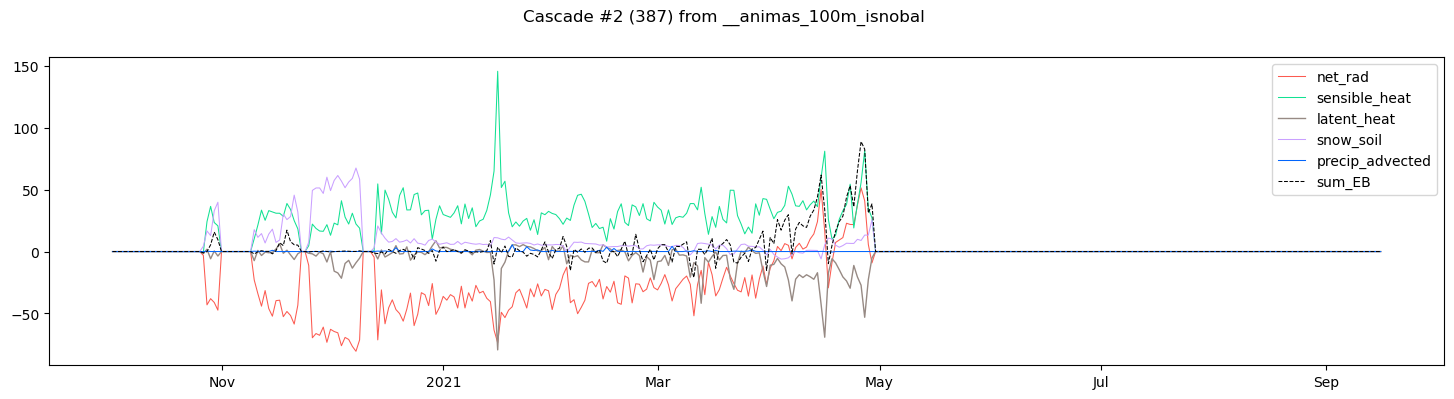

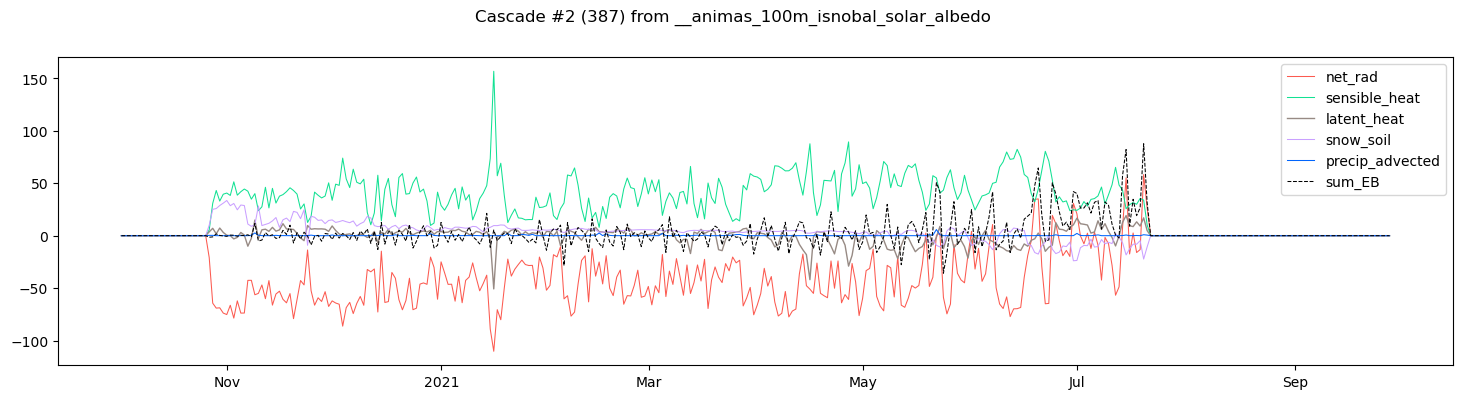

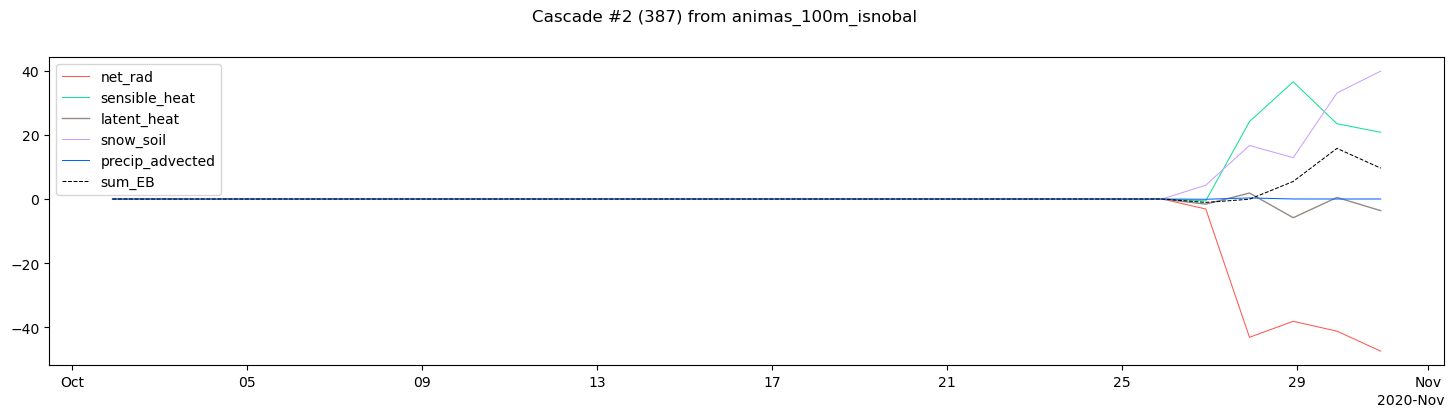

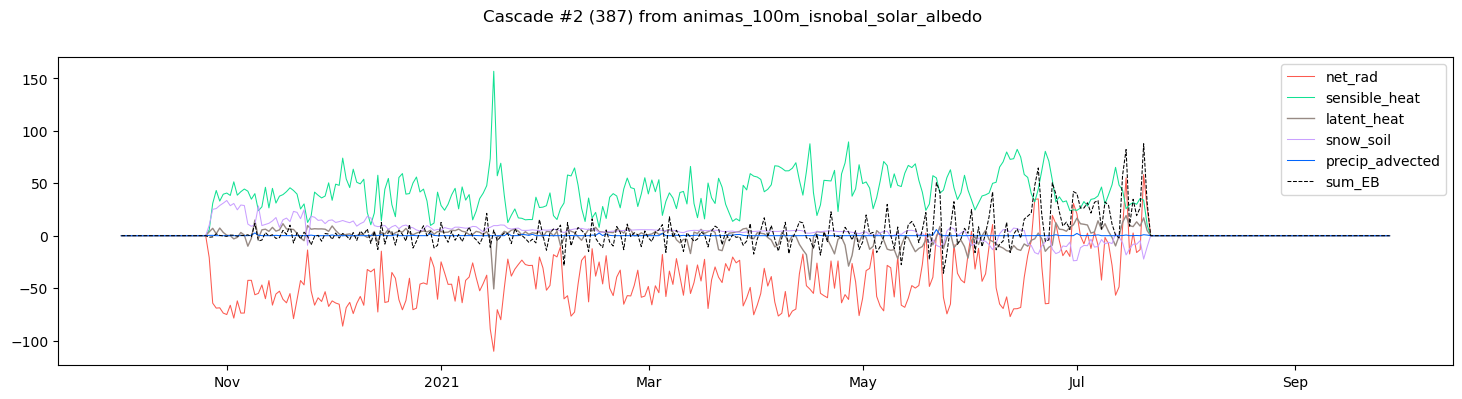

In [88]:
for basindir in complete_dict.keys():
    print(basindir)
    var_ts_dict = complete_dict[basindir]

    fig, ax = plt.subplots(figsize=(18, 4))
    for jdx, thisvar in enumerate(var_ts_dict.keys()):
        var_ts_dict[thisvar].plot(x='time', ax=ax, label=thisvar, color=colors[jdx], linewidth=linewidths[jdx], linestyle=linestyles[jdx])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    # ax.set_xlim([var_ts_dict[thisvar].time.values[0], var_ts_dict[thisvar].time.values[-75]])
    plt.suptitle(f'{sitename} from {basindir}', y=1.0);
    plt.legend();

In [94]:
var_ts_dict.keys()

dict_keys(['net_rad', 'sensible_heat', 'latent_heat', 'snow_soil', 'precip_advected', 'sum_EB'])

In [115]:
complete_dict[list(complete_dict.keys())[0]]

{'net_rad': <xarray.DataArray 'net_rad' (time: 350)> Size: 1kB
 array([  0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         -3.109071 , -43.082787 , -38.103195 , -41.17409  , -47.387684 ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       , -22.992373 ,
        -34.03008  , -44.152107 , -31.537096 , -46.10052  , -52.277027 ,
        -39.68665  , -39.32486  , -52.662403 , -48.458973 , -51.697815 ,
        -58.633892 , -43.358505 ,   0.       ,   0.       , -11.245245 ,
        -69.72068  , -66.28572  , -67.71642  , -61.054626 , -73.38189  ,
        -62.857986 , -64.641    , -65.68411  , -76.15517  , -

net_rad
sensible_heat
latent_heat
snow_soil
precip_advected
sum_EB


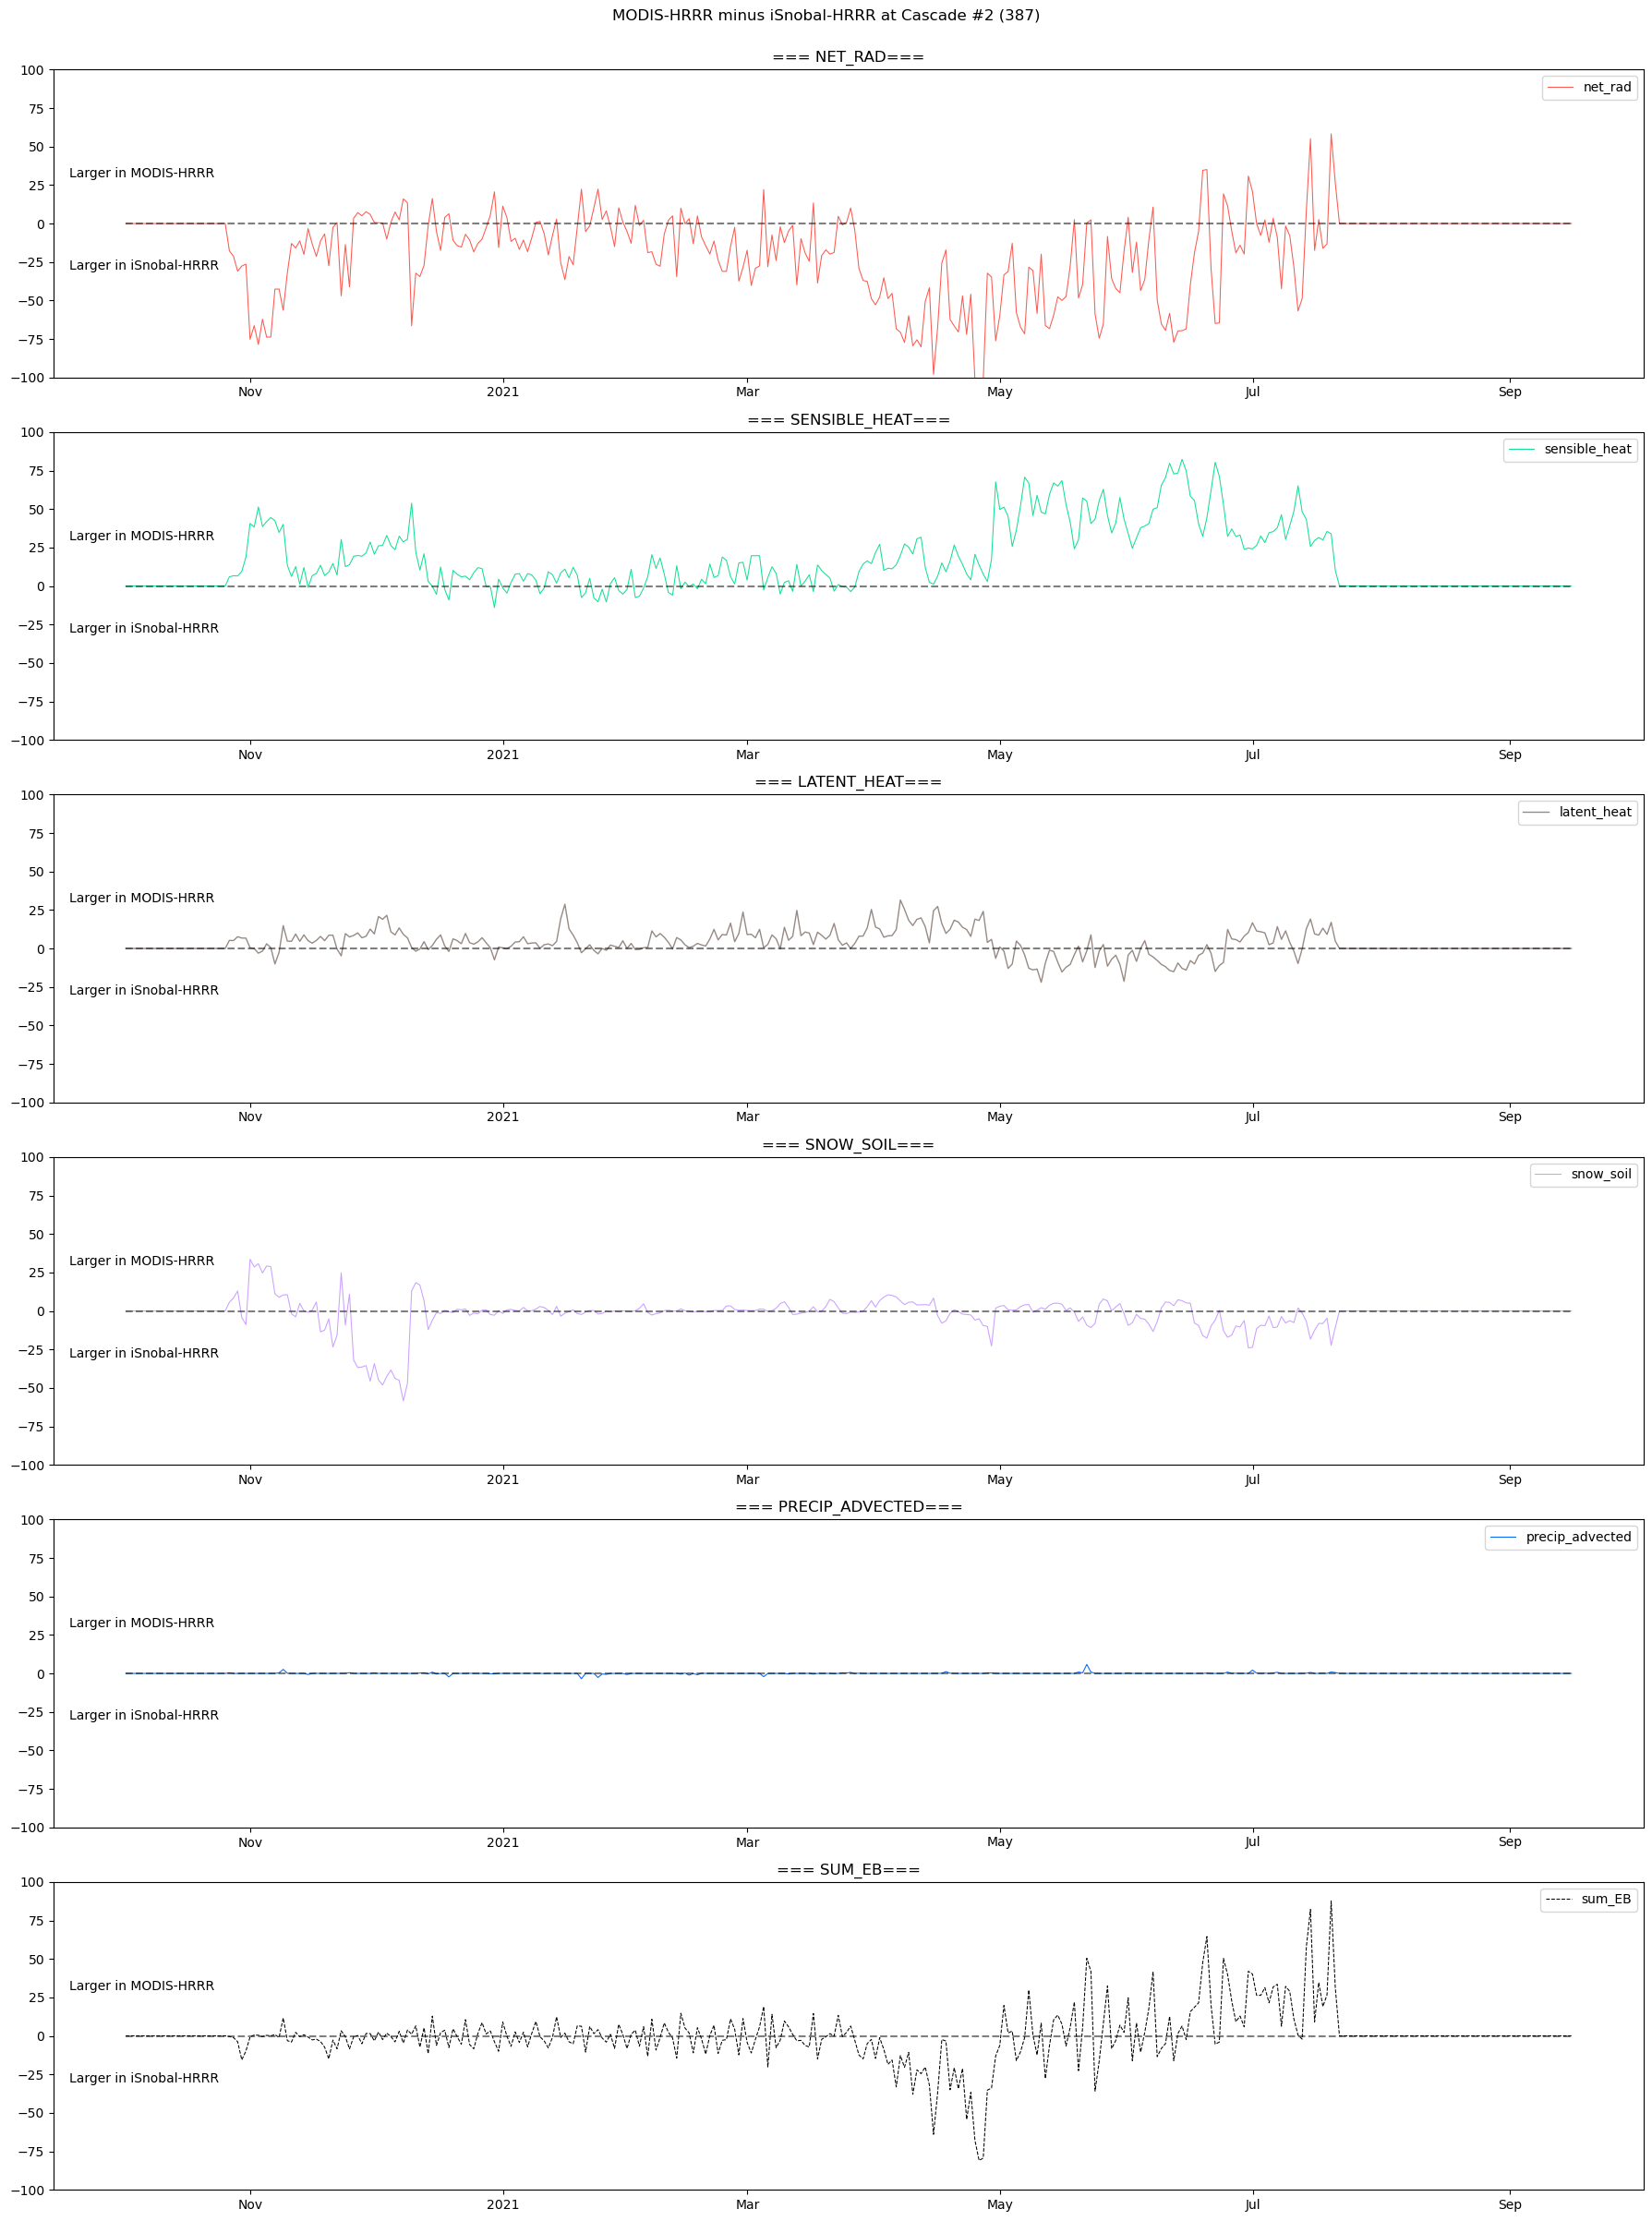

In [135]:
# Ok, compare the older MODIS-HRRR against the iSnobal-HRRR runs. These are the first two keys in the complete_dict
isnobal_hrrr_dict = complete_dict[list(complete_dict.keys())[0]]
modis_hrrr_dict = complete_dict[list(complete_dict.keys())[1]]

fig, axa = plt.subplots(6, 1, figsize=(18, 24))
for jdx, term in enumerate(var_ts_dict.keys()):
    ax = axa.flatten()[jdx]
    print(term)
    diff = modis_hrrr_dict[term] - isnobal_hrrr_dict[term]
    diff.plot(x='time', ax=ax, label=term, color=colors[jdx], linewidth=linewidths[jdx], linestyle=linestyles[jdx])
    ax.set_ylim([-100, 100])
    ax.hlines(0, diff.time.values[0], diff.time.values[-1], color='k', linestyle='--', alpha=0.5)
    # Add annotation
    ax.annotate(f'Larger in MODIS-HRRR', xy=(0.01, 0.65), xycoords='axes fraction')
    ax.annotate(f'Larger in iSnobal-HRRR', xy=(0.01, 0.35), xycoords='axes fraction')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    ax.legend();
    ax.set_title(f'=== {term.upper()}===', y=1.0);
plt.suptitle(f'MODIS-HRRR minus iSnobal-HRRR at {sitename}', y=1.0);
plt.tight_layout();
    

## Finally, though this isn't really directly EB, toss in the albedo comparison between these two

for MODIS-HRRR, this is `albedo` within net_solar.nc  
for iSnobal-HRRR, this is `albedo_ir` in albedo_ir.nc or `albedo_vis` in albedo_vis.nc


In [139]:
albedo_dict = dict()
for basindir in h.fn_list(workdir, f'__{basin}*'):
    print(PurePath(basindir).name)
    # Match for iSnobal-HRRR first
    albedo_fnlist = h.fn_list(basindir, f'*{WY}/*/run*/albedo_vis.nc')
    thisvar = 'albedo_vis'
    # If no albedo_vis.nc files, try net_solar.nc files for MODIS-HRRR run
    if len(albedo_fnlist) == 0:
        albedo_fnlist = h.fn_list(basindir, f'*{WY}/*/run*/net_solar.nc')
        thisvar = 'albedo'
    print(len(albedo_fnlist))
    albedo_list = [xr.open_dataset(thisfn) for thisfn in albedo_fnlist]
    print(len(albedo_list))

    # to get data_vars (terms)
    ds_list = albedo_list[0]
    var_ts_dict = dict()

    var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in albedo_list]
    
    # Concatenate all the days
    var_data = np.squeeze(xr.concat(var_data, dim='time'))
    var_ts_dict[thisvar] = var_data
    albedo_dict[PurePath(basindir).name] = var_ts_dict

__animas_100m_isnobal
351
351
__animas_100m_isnobal_solar_albedo
365
365


In [144]:
albedo_dict[list(albedo_dict.keys())[0]].keys()

dict_keys(['albedo_vis'])

# PICK UP FROM HERE Get this to plot

In [200]:
isnobal_hrrr_10AM_extract

<xarray.DataArray 'albedo_vis' (time: 350)> Size: 1kB
array([0.974056  , 0.9675376 , 0.96333295, 0.9605679 , 0.9586703 ,
       0.95731854, 0.95632756, 0.9555857 , 0.95502263, 0.9545918 ,
       0.95426166, 0.95400965, 0.9538197 , 0.95368   , 0.9535811 ,
       0.9535163 , 0.95348   , 0.9534679 , 0.9534764 , 0.9535028 ,
       0.95354444, 0.95359963, 0.9536666 , 0.953744  , 0.9538306 ,
       0.981737  , 0.97634256, 0.9704264 , 0.9666264 , 0.9641417 ,
       0.9624488 , 0.9612532 , 0.9603859 , 0.9597449 , 0.95926535,
       0.95890504, 0.958635  , 0.95843446, 0.9582889 , 0.9827497 ,
       0.9776583 , 0.9720752 , 0.968491  , 0.96614826, 0.98310214,
       0.9778353 , 0.97245854, 0.9690088 , 0.9667487 , 0.9652048 ,
       0.96411103, 0.96331406, 0.96272135, 0.9622742 , 0.98376256,
       0.9789628 , 0.97369546, 0.9703063 , 0.9680832 , 0.9665609 ,
       0.9654777 , 0.96468323, 0.9640867 , 0.96363074, 0.9632776 ,
       0.9630015 , 0.9627841 , 0.9626124 , 0.96247643, 0.9623688 ,
       0.96228385, 0.96221703, 0.96216494, 0.9830924 , 0.97718686,
       0.98022664, 0.97523665, 0.9720001 , 0.9848892 , 0.98038393,
       0.9754224 , 0.972197  , 0.9700502 , 0.968551  , 0.9674569 ,
       0.9666283 , 0.96598136, 0.9654627 , 0.9850791 , 0.9850873 ,
       0.9806137 , 0.9756756 , 0.9724437 , 0.9702726 , 0.9687387 ,
       0.9676032 , 0.96672887, 0.9660331 , 0.9654633 , 0.96498525,
...
       0.73984385, 0.73982555, 0.7398104 , 0.7397983 , 0.73978925,
       0.7397829 , 0.7397795 , 0.7397785 , 0.7397802 , 0.73978424,
       0.73979074, 0.7397994 , 0.73981035, 0.73982346, 0.73983866,
       0.7398558 , 0.739875  , 0.739896  , 0.73991895, 0.73994356,
       0.7399699 , 0.739998  , 0.74002767, 0.7400589 , 0.7400916 ,
       0.74012583, 0.7401614 , 0.7401984 , 0.74023664, 0.7402761 ,
       0.74031687, 0.7403588 , 0.74040186, 0.7404461 , 0.7404913 ,
       0.7405377 , 0.7405851 , 0.74063355, 0.740683  , 0.7407335 ,
       0.740785  , 0.74083745, 0.74089104, 0.7409455 , 0.7410012 ,
       0.74105775, 0.7411154 , 0.74117416, 0.7412339 , 0.7412947 ,
       0.7413565 , 0.74141955, 0.7414835 , 0.74154866, 0.74161476,
       0.74168205, 0.74175036, 0.7418198 , 0.7418904 , 0.74196196,
       0.7420347 , 0.7421086 , 0.74218357, 0.7422597 , 0.74233705,
       0.74241555, 0.74249524, 0.7425763 , 0.7426586 , 0.7427422 ,
       0.7428271 , 0.7429133 , 0.74300104, 0.74309015, 0.7431809 ,
       0.7432731 , 0.7433668 , 0.74346215, 0.7435591 , 0.74365777,
       0.74375796, 0.7438599 , 0.74396354, 0.7440689 , 0.744176  ,
       0.7442848 , 0.7443954 , 0.7445076 , 0.7446217 , 0.74473757,
       0.74485517, 0.7449747 , 0.7450959 , 0.745219  , 0.74533373],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2020-10-01T16:00:00 ... 2021-09-15T16:...
    y        float32 4B 4.172e+06
    x        float32 4B 2.53e+05
Attributes:
    module:        albedo
    units:         None
    long_name:     Visible wavelength albedo
    grid_mapping:  projection

KeyError: 'albedo_vis'

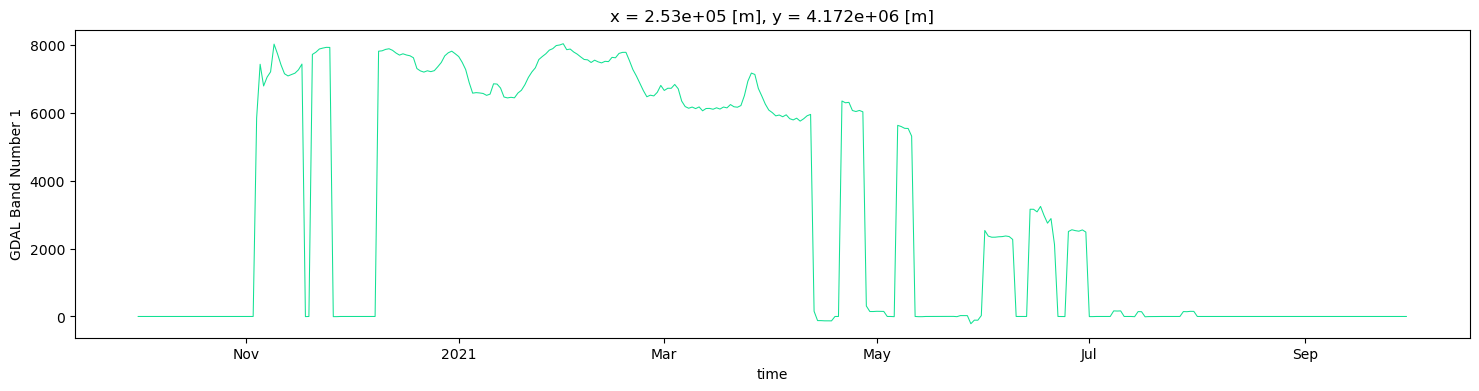

In [199]:
# Ok, compare the older MODIS-HRRR against the iSnobal-HRRR runs. These are the first two keys in the complete_dict
isnobal_hrrr_dict_albedo = albedo_dict[list(albedo_dict.keys())[0]]
modis_hrrr_dict_albedo = albedo_dict[list(albedo_dict.keys())[1]]

fig, ax = plt.subplots(1, 1, figsize=(18, 4))
modis_hrrr_dict_albedo['albedo'].resample(time='D').mean().plot(x='time', ax=ax, label='MODIS-HRRR BB albedo', color=colors[1], linewidth=linewidths[jdx], linestyle=linestyles[jdx])
(isnobal_hrrr_10AM_extract['albedo_vis'] * 10000).resample(time='D').mean().plot(x='time', ax=ax, label='iSnobal-HRRR albedo_vis', color=colors[2], linewidth=linewidths[jdx], linestyle=linestyles[jdx])
# (isnobal_hrrr_dict_albedo['albedo_vis'] * 10000).resample(time='16H').mean().plot(x='time', ax=ax, label='iSnobal-HRRRR albedo_vis', color=colors[2], linewidth=linewidths[jdx], linestyle=linestyles[jdx])
ax.hlines(0, diff.time.values[0], diff.time.values[-1], color='k', linestyle='--', alpha=0.5)
# Add annotation
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.legend();
plt.suptitle(f'Albedo values at {sitename}', y=1.0);
plt.tight_layout();  

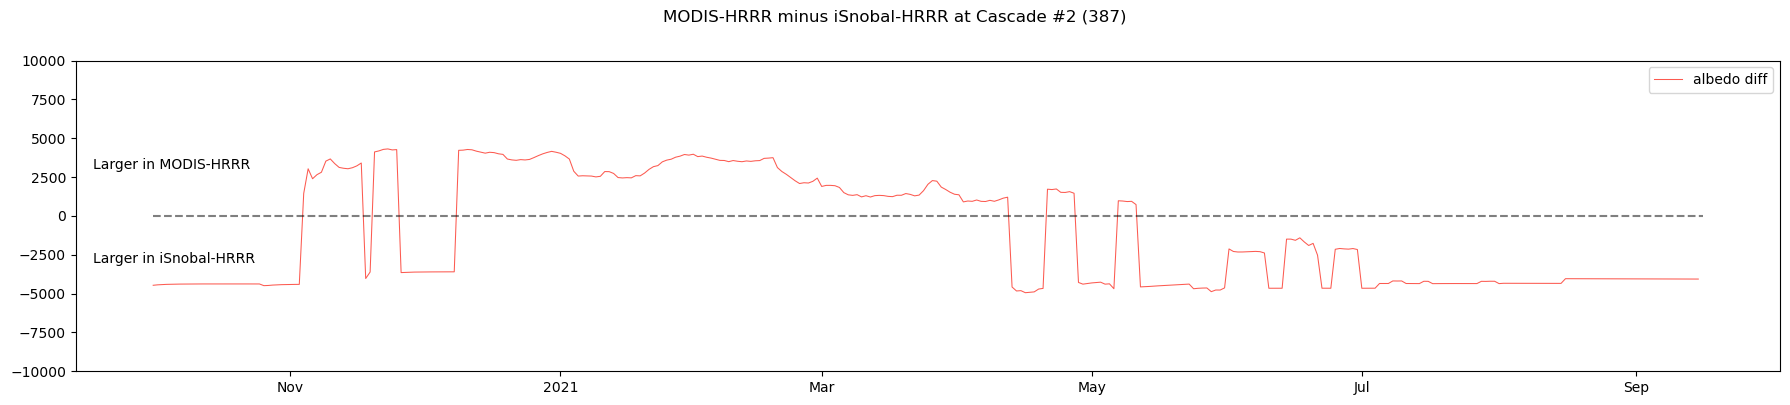

In [161]:
# Ok, compare the older MODIS-HRRR against the iSnobal-HRRR runs. These are the first two keys in the complete_dict
fig, ax = plt.subplots(1, 1, figsize=(18, 4))
diff = modis_hrrr_dict_albedo['albedo'] - isnobal_hrrr_dict_albedo['albedo_vis'] * 10000
diff.resample(time='D').mean().plot(x='time', ax=ax, label='albedo diff', color=colors[0], linewidth=linewidths[jdx], linestyle=linestyles[jdx])
ax.set_ylim([-10000, 10000])
ax.hlines(0, diff.time.values[0], diff.time.values[-1], color='k', linestyle='--', alpha=0.5)
# Add annotation
ax.annotate(f'Larger in MODIS-HRRR', xy=(0.01, 0.65), xycoords='axes fraction')
ax.annotate(f'Larger in iSnobal-HRRR', xy=(0.01, 0.35), xycoords='axes fraction')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.legend();
plt.suptitle(f'MODIS-HRRR minus iSnobal-HRRR at {sitename}', y=1.0);
plt.tight_layout();  

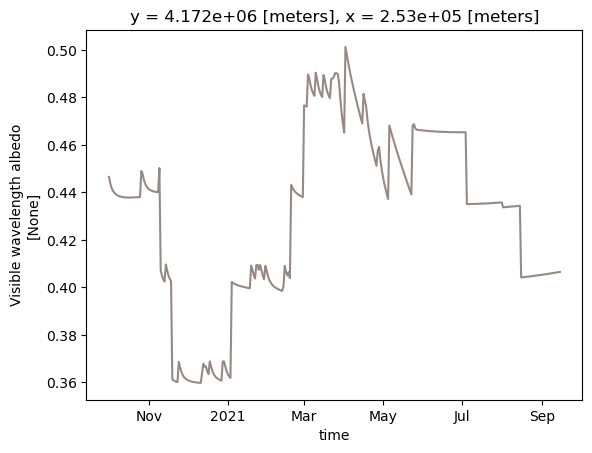

In [160]:
# Plot daily average
isnobal_hrrr_dict_albedo['albedo_vis'].resample(time='D').mean().plot(label='iSnobal-HRRR albedo_vis', color=colors[2])

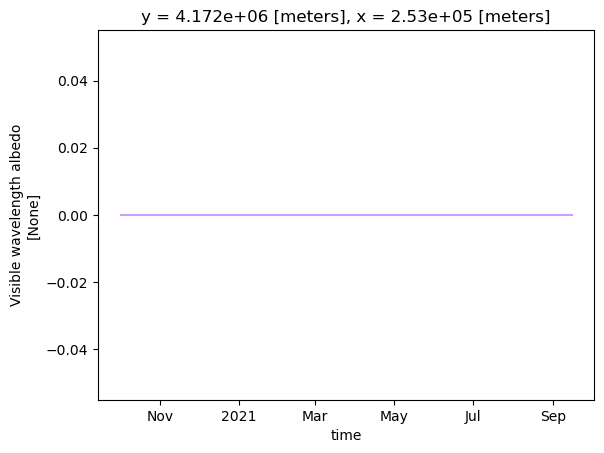

In [169]:
# Extract only the 10 am values
isnobal_hrrr_dict_albedo['albedo_vis'].sel(time=isnobal_hrrr_dict_albedo['albedo_vis'].time.dt.hour == 10).plot(label='iSnobal-HRRR albedo_vis 10 am', color=colors[3])

In [183]:
isnobal_hrrr_dict_albedo['albedo_vis'].time.dt.hour

<xarray.DataArray 'hour' (time: 8400)> Size: 67kB
array([ 0,  1,  2, ..., 21, 22, 23])
Coordinates:
  * time     (time) datetime64[ns] 67kB 2020-10-01 ... 2021-09-15T23:00:00
    y        float32 4B 4.172e+06
    x        float32 4B 2.53e+05
Attributes:
    time_zone:  utc
    long_name:  time

/scratch/local/u6058223/ipykernel_2416773/64778028.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


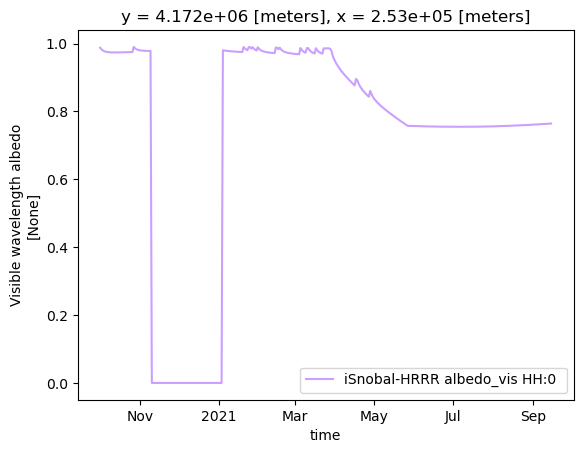

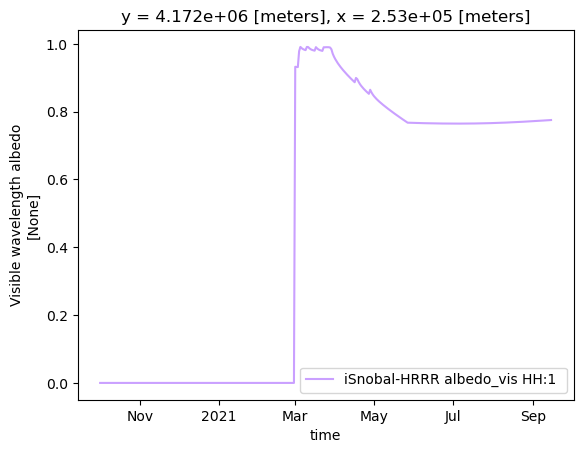

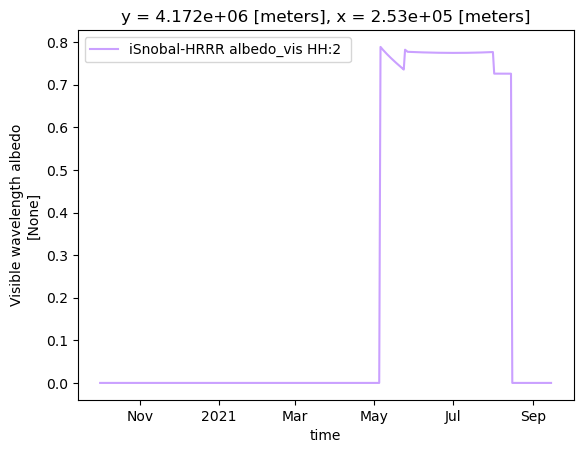

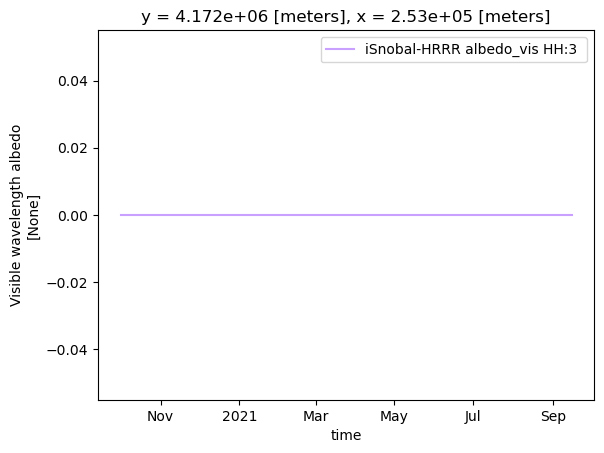

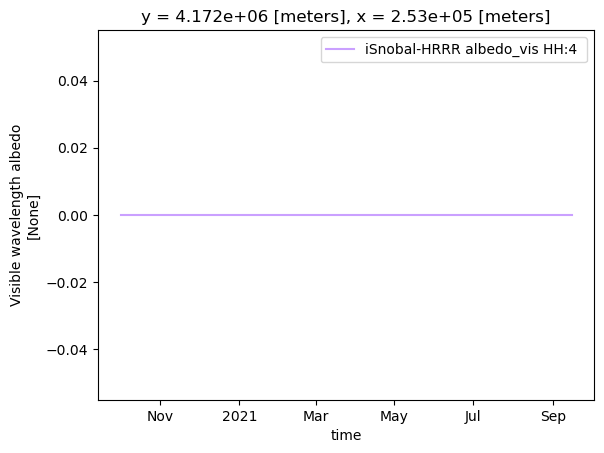

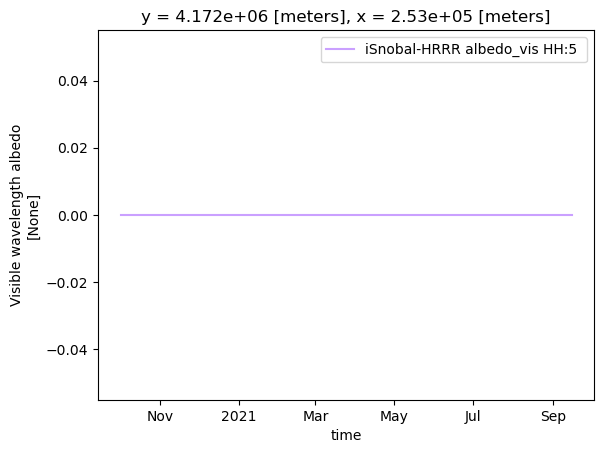

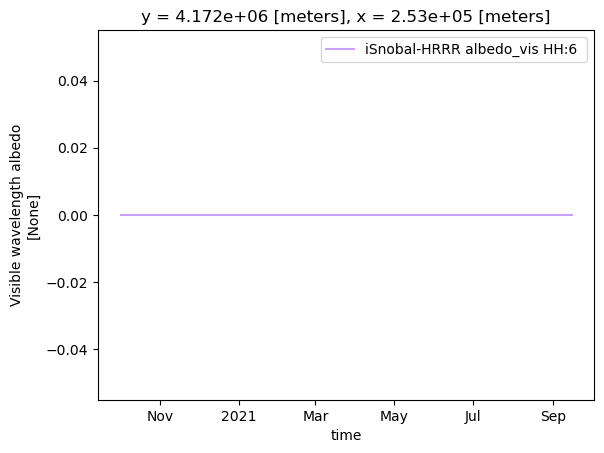

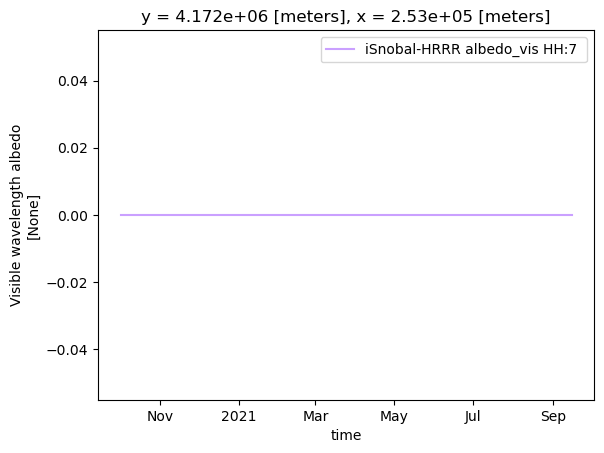

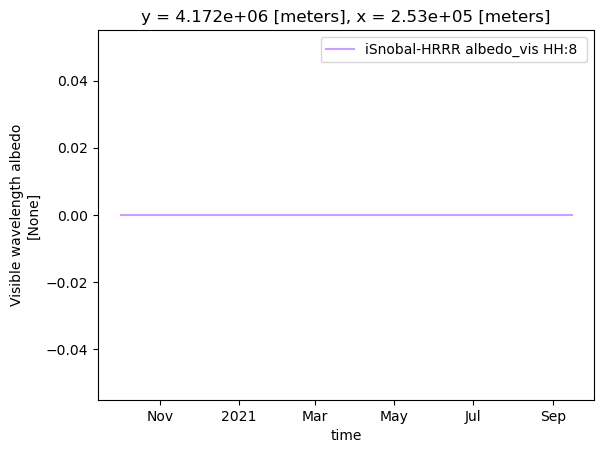

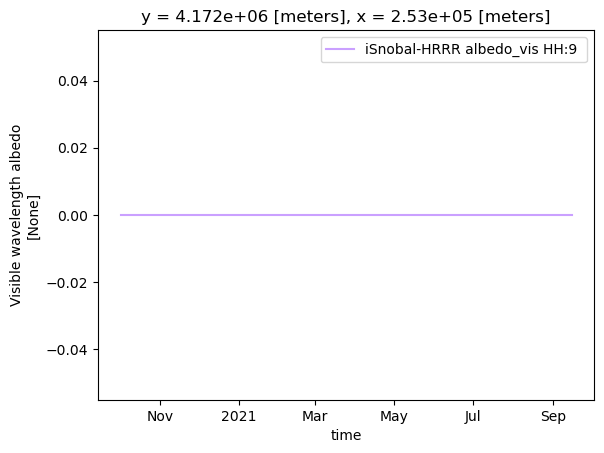

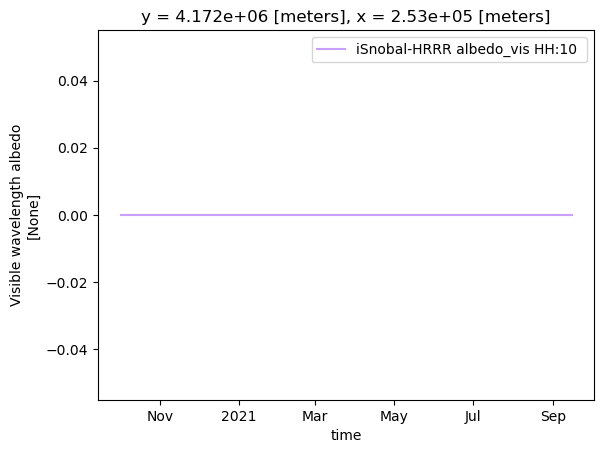

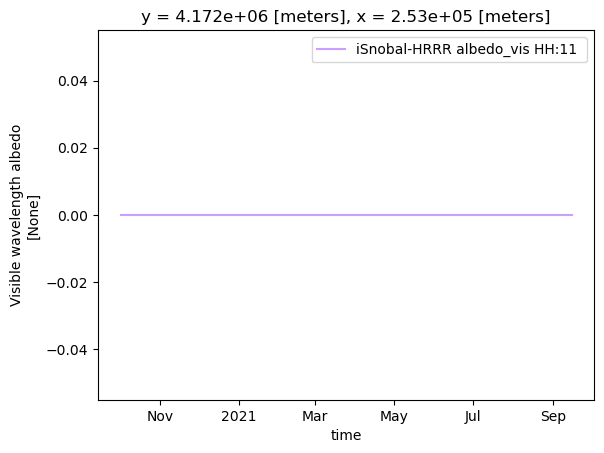

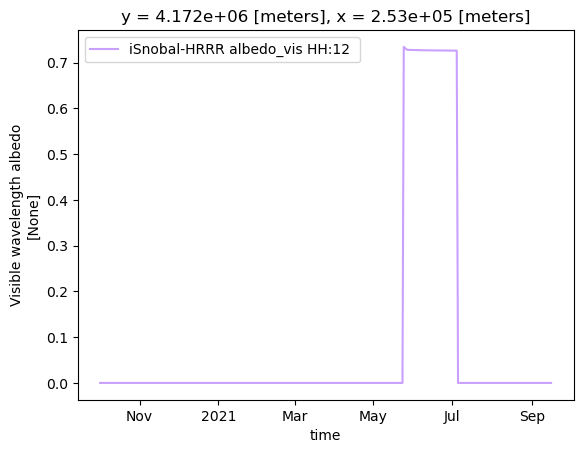

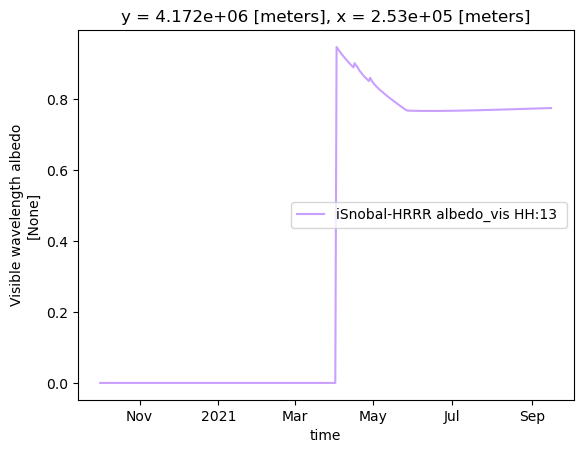

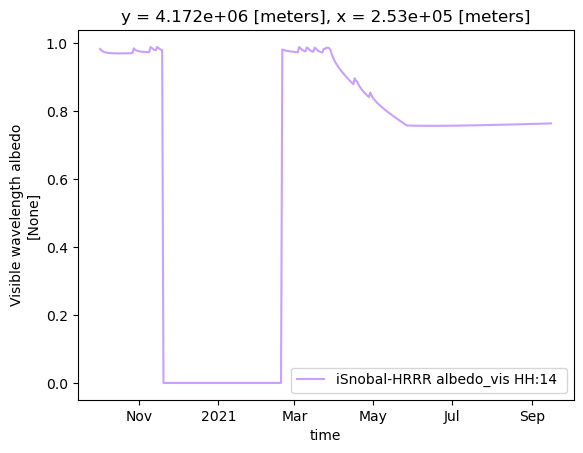

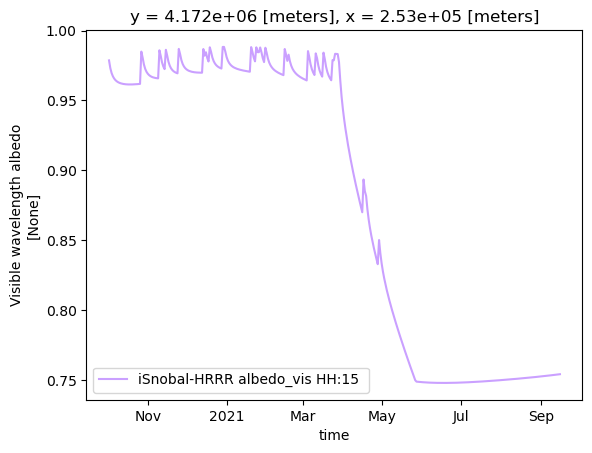

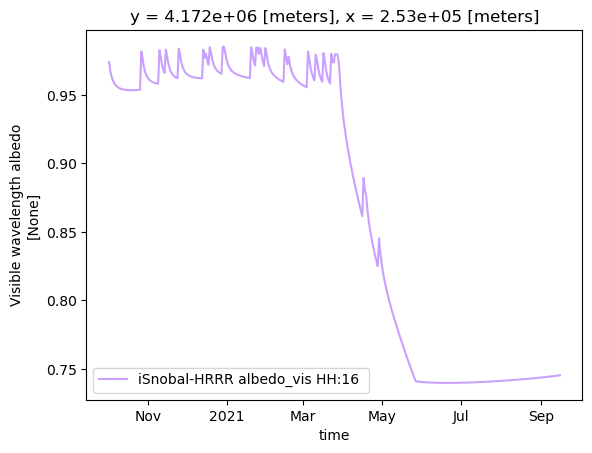

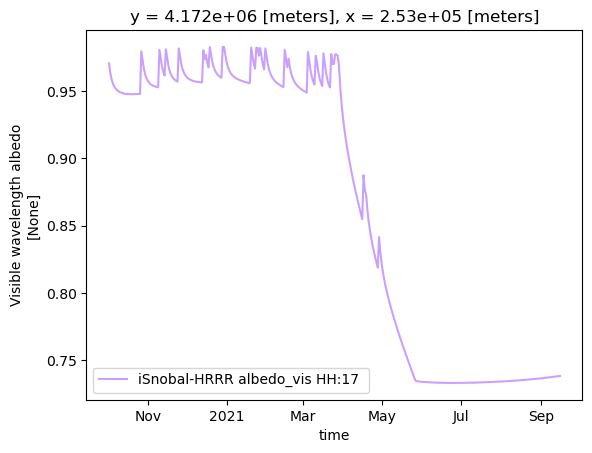

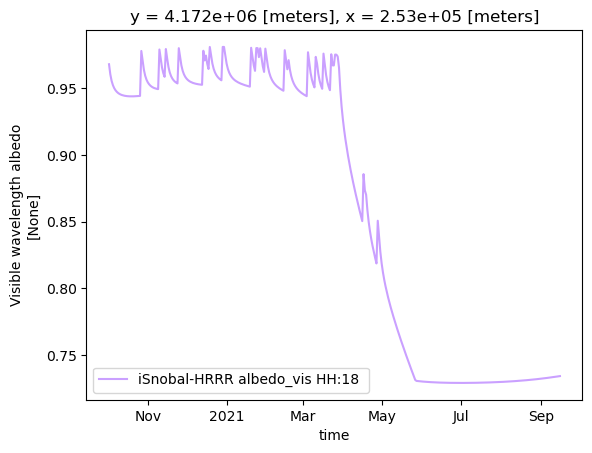

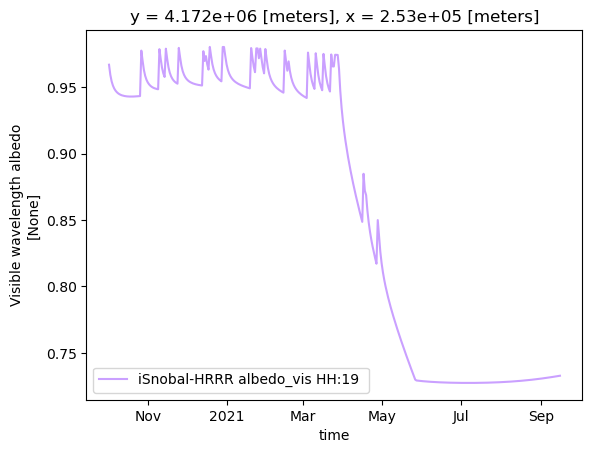

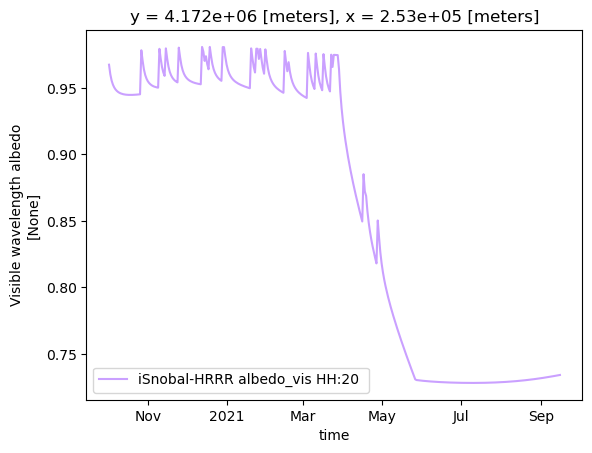

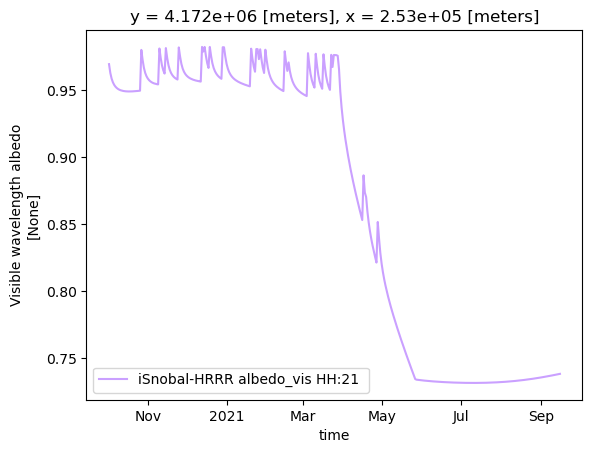

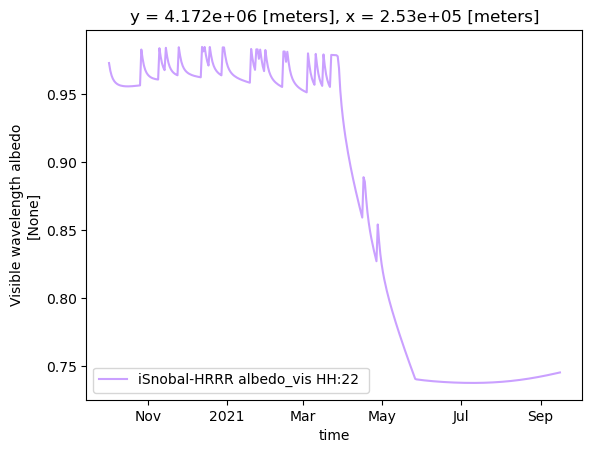

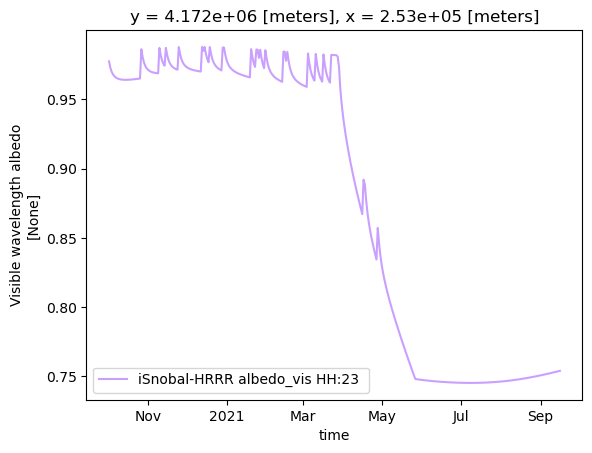

In [193]:
for f in np.unique(isnobal_hrrr_dict_albedo['albedo_vis'].time.dt.hour.values):
    # print(f)
    plt.figure()
    isnobal_hrrr_extract = isnobal_hrrr_dict_albedo['albedo_vis'][isnobal_hrrr_dict_albedo['albedo_vis'].time.dt.hour == f]
    isnobal_hrrr_extract.plot(label=f'iSnobal-HRRR albedo_vis HH:{f} ', color=colors[3])
    plt.legend()
    
    

**Note hours are in UTC, so they are shifted 6 hours later from MST -- starting plot is at 6PM MST**  
To plot 10 AM MST, need to plot 16 UTC

In [195]:
isnobal_hrrr_10AM_extract = isnobal_hrrr_dict_albedo['albedo_vis'][isnobal_hrrr_dict_albedo['albedo_vis'].time.dt.hour == 16]
isnobal_hrrr_10AM_extract

<xarray.DataArray 'albedo_vis' (time: 350)> Size: 1kB
array([0.974056  , 0.9675376 , 0.96333295, 0.9605679 , 0.9586703 ,
       0.95731854, 0.95632756, 0.9555857 , 0.95502263, 0.9545918 ,
       0.95426166, 0.95400965, 0.9538197 , 0.95368   , 0.9535811 ,
       0.9535163 , 0.95348   , 0.9534679 , 0.9534764 , 0.9535028 ,
       0.95354444, 0.95359963, 0.9536666 , 0.953744  , 0.9538306 ,
       0.981737  , 0.97634256, 0.9704264 , 0.9666264 , 0.9641417 ,
       0.9624488 , 0.9612532 , 0.9603859 , 0.9597449 , 0.95926535,
       0.95890504, 0.958635  , 0.95843446, 0.9582889 , 0.9827497 ,
       0.9776583 , 0.9720752 , 0.968491  , 0.96614826, 0.98310214,
       0.9778353 , 0.97245854, 0.9690088 , 0.9667487 , 0.9652048 ,
       0.96411103, 0.96331406, 0.96272135, 0.9622742 , 0.98376256,
       0.9789628 , 0.97369546, 0.9703063 , 0.9680832 , 0.9665609 ,
       0.9654777 , 0.96468323, 0.9640867 , 0.96363074, 0.9632776 ,
       0.9630015 , 0.9627841 , 0.9626124 , 0.96247643, 0.9623688 ,
       0.96228385, 0.96221703, 0.96216494, 0.9830924 , 0.97718686,
       0.98022664, 0.97523665, 0.9720001 , 0.9848892 , 0.98038393,
       0.9754224 , 0.972197  , 0.9700502 , 0.968551  , 0.9674569 ,
       0.9666283 , 0.96598136, 0.9654627 , 0.9850791 , 0.9850873 ,
       0.9806137 , 0.9756756 , 0.9724437 , 0.9702726 , 0.9687387 ,
       0.9676032 , 0.96672887, 0.9660331 , 0.9654633 , 0.96498525,
...
       0.73984385, 0.73982555, 0.7398104 , 0.7397983 , 0.73978925,
       0.7397829 , 0.7397795 , 0.7397785 , 0.7397802 , 0.73978424,
       0.73979074, 0.7397994 , 0.73981035, 0.73982346, 0.73983866,
       0.7398558 , 0.739875  , 0.739896  , 0.73991895, 0.73994356,
       0.7399699 , 0.739998  , 0.74002767, 0.7400589 , 0.7400916 ,
       0.74012583, 0.7401614 , 0.7401984 , 0.74023664, 0.7402761 ,
       0.74031687, 0.7403588 , 0.74040186, 0.7404461 , 0.7404913 ,
       0.7405377 , 0.7405851 , 0.74063355, 0.740683  , 0.7407335 ,
       0.740785  , 0.74083745, 0.74089104, 0.7409455 , 0.7410012 ,
       0.74105775, 0.7411154 , 0.74117416, 0.7412339 , 0.7412947 ,
       0.7413565 , 0.74141955, 0.7414835 , 0.74154866, 0.74161476,
       0.74168205, 0.74175036, 0.7418198 , 0.7418904 , 0.74196196,
       0.7420347 , 0.7421086 , 0.74218357, 0.7422597 , 0.74233705,
       0.74241555, 0.74249524, 0.7425763 , 0.7426586 , 0.7427422 ,
       0.7428271 , 0.7429133 , 0.74300104, 0.74309015, 0.7431809 ,
       0.7432731 , 0.7433668 , 0.74346215, 0.7435591 , 0.74365777,
       0.74375796, 0.7438599 , 0.74396354, 0.7440689 , 0.744176  ,
       0.7442848 , 0.7443954 , 0.7445076 , 0.7446217 , 0.74473757,
       0.74485517, 0.7449747 , 0.7450959 , 0.745219  , 0.74533373],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2020-10-01T16:00:00 ... 2021-09-15T16:...
    y        float32 4B 4.172e+06
    x        float32 4B 2.53e+05
Attributes:
    module:        albedo
    units:         None
    long_name:     Visible wavelength albedo
    grid_mapping:  projection